# Importing packages and datafiles

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.sparse import csr_matrix
import time, re, os

#to allow for progress tracking
from tqdm import tqdm
tqdm.pandas()

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, precision_score,  f1_score, recall_score # for model performance assessment
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

#manual way of doing preprocessing
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer # RegexpTokenizer uses regex for tokenization
from nltk.stem import WordNetLemmatizer # for lemmatization
from nltk.stem.porter import PorterStemmer # for stemming
from nltk.corpus import stopwords # for stopwords removal
from nltk.sentiment.vader import SentimentIntensityAnalyzer # analyze sentiments using Vader library (implemented from technical paper)

#pycaret
from pycaret.classification import *

# imports for contextual embeddings
from transformers import pipeline # loading pre-trained models for contextual word embeddings (Hugging Face)

In [2]:
philosophy_org = pd.read_csv('datasets/philosophy.csv')
science_org = pd.read_csv('datasets/science.csv')

# EDA

In [3]:
science_org.shape

(24961, 82)

In [4]:
philosophy_org.shape

(24988, 83)

## Title length between both subreddits

In [5]:
title = pd.DataFrame()
title['science'] = science_org['title'].apply(len)
title['philosophy'] = philosophy_org['title'].apply(len)
title.dropna(inplace = True)

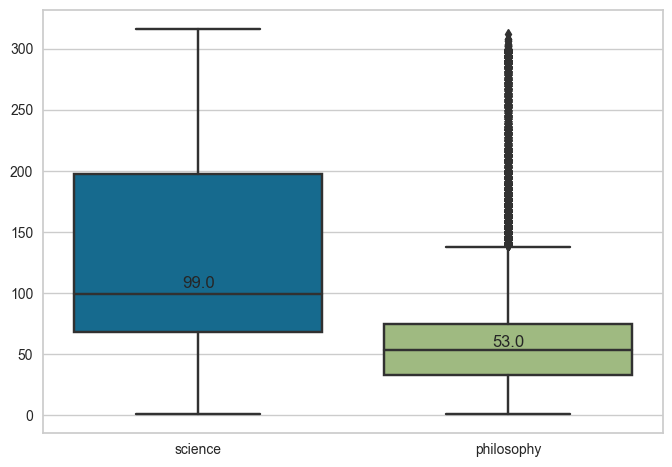

In [6]:
box_plot = sns.boxplot(data = title)
medians = title.median()
vertical_offset = title.median() * 1.05 # offset from median for display

for xtick in box_plot.get_xticks():
    box_plot.annotate(medians[xtick], xy=(xtick-0.05, vertical_offset[xtick]))


$H_0:$ The true mean difference in title length between science and philosophy is 0.

$H_A:$ The true mean difference in title length between science and philosophy is NOT 0.

In [7]:
_, p_value = stats.ttest_ind(title['science'], title['philosophy'])
p_value

0.0

Because our p-value was below 0.05, we reject the null hypothesis and conclude that the there is a difference between title length for science and philosophy subreddits

## Number of submission deleted by moderators
This is indicated when selftext is marked as `[removed]`

In [8]:
mod_removed = pd.DataFrame({
    'count':{
        'science':science_org['selftext'][science_org['selftext'] == '[removed]'].count(),
        'philosophy':philosophy_org['selftext'][philosophy_org['selftext'] == '[removed]'].count()
    },
    'percent':{
        'science':science_org['selftext'][science_org['selftext'] == '[removed]'].count()/len(science_org),
        'philosophy':philosophy_org['selftext'][philosophy_org['selftext'] == '[removed]'].count()/len(philosophy_org)
    },
})

In [9]:
mod_removed

,count,percent
science,0,0.000000
philosophy,13997,0.560149


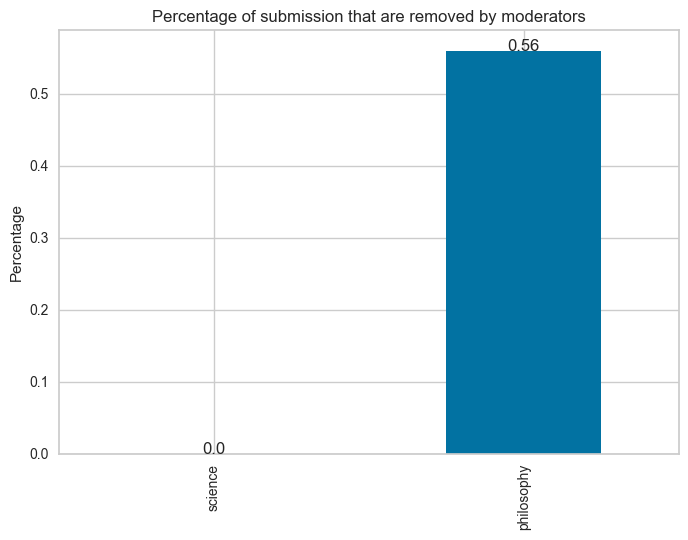

In [10]:
mod_removed['percent'].plot.bar()
plt.title('Percentage of submission that are removed by moderators')
plt.ylabel('Percentage')

for i in range(len(mod_removed['percent'])):
    plt.text(i, mod_removed['percent'][i], round(mod_removed['percent'][i],2), ha = 'center')

## Selftext occurence between both subreddits

In [11]:
def clean_selftext(x):
    if x == '[removed]':
        return np.nan
philosophy_selftext = philosophy_org['selftext'].apply(clean_selftext)

In [12]:
selftext = pd.DataFrame({
    'occurence':{
        'science':len(science_org[science_org['selftext'].notnull()]),
        'philosophy':len(philosophy_selftext[philosophy_selftext.notnull()])
    },
    'percent':{
        'science':len(science_org[science_org['selftext'].notnull()])/len(science_org)*100,
        'philosophy':len(philosophy_selftext[philosophy_selftext.notnull()])/len(philosophy_selftext)*100
    },
})

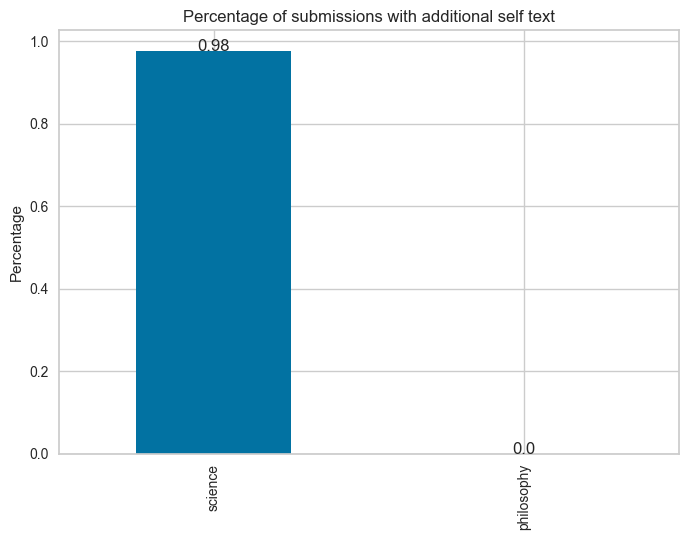

In [13]:
selftext['percent'].plot.bar()
plt.title('Percentage of submissions with additional self text')
plt.ylabel('Percentage')

for i in range(len(selftext['percent'])):
    plt.text(i, selftext['percent'][i], round(selftext['percent'][i],2), ha = 'center')

After cleaning the posts that are removed by mods, Science subreddit's has comparatively more submission that have self text. 

## Top 10 common domain shared in each subreddits


In [14]:
def get_domain(url):
    if type(url) == str:
        return str(url).split('/')[2]

In [15]:
get_domain(philosophy_org['url'][1])

'www.reddit.com'

In [16]:
domain = pd.DataFrame()

domain['science'] = science_org['url'].apply(get_domain)
domain['philosophy'] = philosophy_org['url'].apply(get_domain)

In [17]:
domain_science_10 = domain['science'].value_counts(ascending=False).head(10)

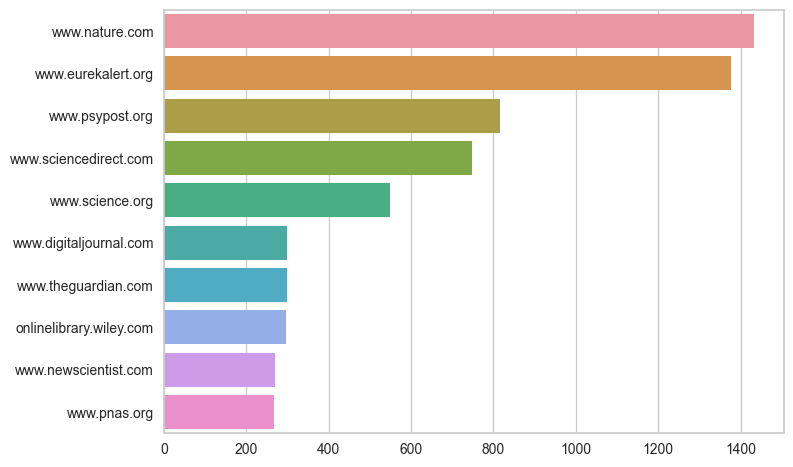

In [18]:
bar_plot = sns.barplot(y=domain_science_10.index, x=domain_science_10.values,
            label="Total")

In [19]:
# we filter out those posts that are removed by moderators
domain_philosophy_10 = domain['philosophy'][domain['philosophy']!='www.reddit.com'].value_counts(ascending=False).head(10)

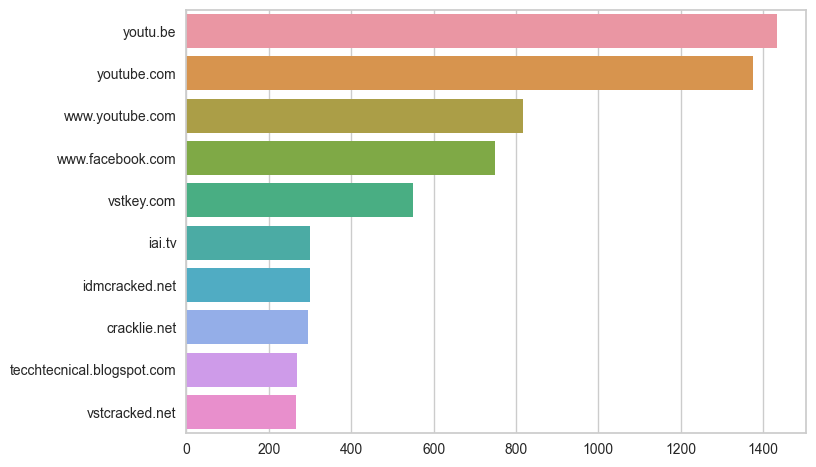

In [20]:
bar_plot = sns.barplot(y=domain_philosophy_10.index, x=domain_science_10.values,
            label="Total")

It seems that for science subreddit, there's alot more link shared to scienctific url, while for philosophy subreddits, there's more link shared to video sites. This is likely to provoke philosophical questions through video.

## Top 10 flair in each subreddits

In [21]:
flair_science = science_org['link_flair_text'].value_counts(ascending=False).head(10)

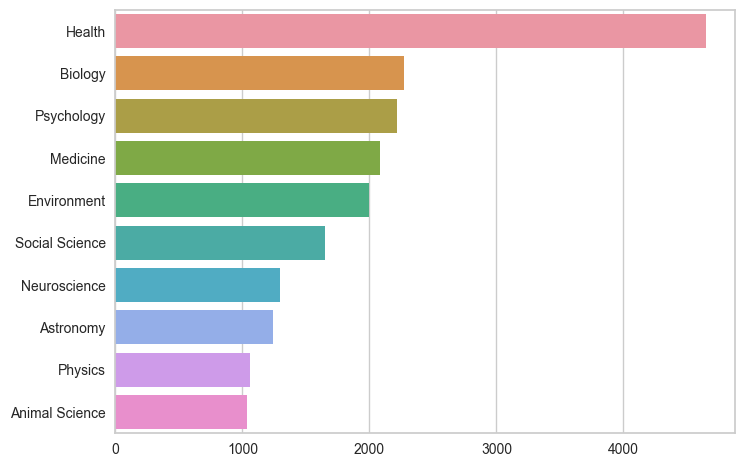

In [22]:
bar_plot = sns.barplot(y=flair_science.index, x=flair_science.values,
            label="Total")

In [23]:
flair_philosophy = philosophy_org['link_flair_text'].value_counts(ascending=False).head(10)

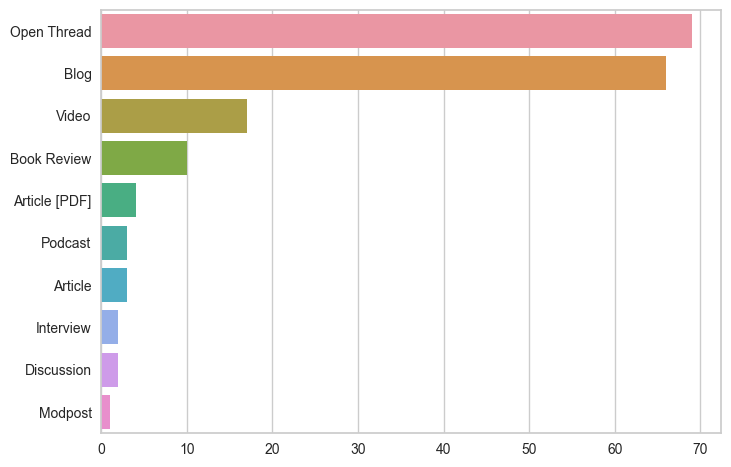

In [24]:
bar_plot = sns.barplot(y=flair_philosophy.index, x=flair_philosophy.values,
            label="Total")

Science subreddit is categorised into different sub sciences, while philosophy subreddit is categorised more as different type of content which are less meaningful in classifying philosophy topics

## Number of original content

In [25]:
science_org['is_original_content'][science_org['is_original_content']==True].count()

0

In [26]:
philosophy_org['is_original_content'][philosophy_org['is_original_content']==True].count()

0

There's no original content marked for both subreddits

## Average number of comments

In [27]:
science_org['num_comments'].sum()

383949

In [28]:
comments = pd.DataFrame({
    'sum':{
        'science':science_org['num_comments'].sum(),
        'philosophy':philosophy_org['num_comments'].sum()
    },
    'average_per_post':{
        'science':science_org['num_comments'].sum()/len(science_org)*100,
        'philosophy':philosophy_org['num_comments'].sum()/len(philosophy_org)*100
    },
})

In [29]:
comments

,sum,average_per_post
science,383949,1538.195585
philosophy,100751,403.197535


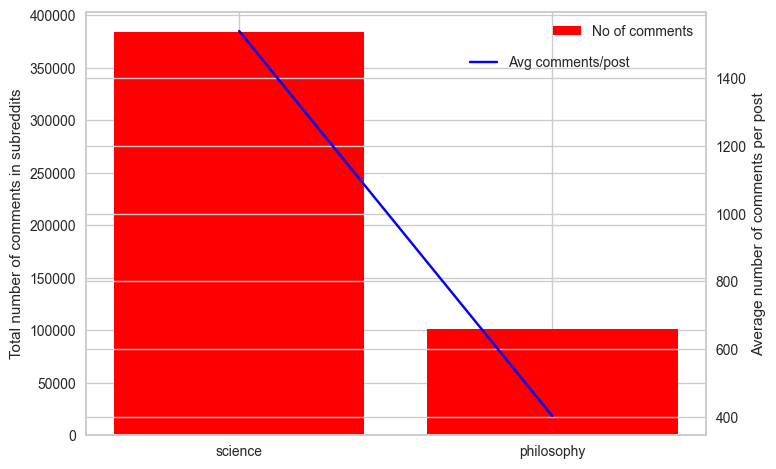

In [30]:
fig = plt.figure()
ax = fig.add_subplot()
ax.bar(comments['sum'].index, comments['sum'].values, color='red', label = 'No of comments')

ax2 = ax.twinx()
ax2.plot(comments['average_per_post'].index, comments['average_per_post'].values, color='blue', label = 'Avg comments/post')

ax.set_ylabel('Total number of comments in subreddits')
ax2.set_ylabel('Average number of comments per post')

ax.legend(loc=0)
ax2.legend(loc=(0.61,0.85));

There's much more comments on science subreddits with more than 3 times the number of comments per posts. This could be due to its subscriber count as well

## Average upvote ratio

In [31]:
upvote = science_org[['upvote_ratio']]

In [32]:
upvote = pd.concat([upvote, philosophy_org[['upvote_ratio']]], axis = 1)
upvote.columns = ['science', 'philosophy']
upvote

,science,philosophy
0,1.0,1.0
1,1.0,1.0
2,1.0,1.0
3,1.0,1.0
4,1.0,1.0
...,...,...
24983,NaN,1.0
24984,NaN,1.0
24985,NaN,1.0
24986,NaN,1.0


In [33]:
upvote.mean()

science       0.997792
philosophy    0.997740
dtype: float64

$H_0:$ The true mean difference in upvote ratio between science and philosophy is 0.

$H_A:$ The true mean difference in upvote ratio between science and philosophy is NOT 0.

In [34]:
upvote.dropna(inplace=True)
_, p_value = stats.ttest_ind(upvote['science'], upvote['philosophy'])
p_value

0.8427437448903075

Because our p-value is above 0.05, we fail to reject the null hypothesis. We do not have enough evidence to conclude that there's a difference between the average upvote ratio between both subreddits

## Subscriber growth vs time

In [35]:
subscriber_science = science_org[['subreddit_subscribers','created_utc']]
subscriber_science['date'] =  science_org.loc[:,'created_utc'].apply(lambda x : time.strftime('%Y-%m-%d', time.localtime(x)))

In [36]:
subscriber_science = subscriber_science[['date', 'subreddit_subscribers']].groupby('date', as_index = False).max()

In [37]:
subscriber_philosophy = philosophy_org[['subreddit_subscribers','created_utc']]
subscriber_philosophy['date'] =  philosophy_org.loc[:,'created_utc'].apply(lambda x : time.strftime('%Y-%m-%d', time.localtime(x)))

In [38]:
subscriber_philosophy = subscriber_philosophy[['date', 'subreddit_subscribers']].groupby('date', as_index = False).max()

In [39]:
subs = pd.merge(left=subscriber_science, right = subscriber_philosophy, on='date')
subs.columns = ['date','science','philosophy']
subs

,date,science,philosophy
0,2021-11-13,26839594,16142765
1,2021-11-14,26842164,16145479
2,2021-11-15,26845035,16148594
3,2021-11-16,26847447,16151237
4,2021-11-17,26849968,16154022
5,2021-11-18,26852835,16156676
6,2021-11-19,26855359,16159145
7,2021-11-20,26857975,16162052
8,2021-11-21,26860561,16164474
9,2021-11-22,26863059,16167168


In [40]:
# We get the incremental growth with earliest date of 13 Nov 2021 as the basis point
subs['science'] = subs['science'] / subs.loc[0,'science']
subs['philosophy'] = subs['philosophy'] / subs.loc[0,'philosophy']

In [41]:
subs['date'].values[::32]

array(['2021-11-13', '2021-12-15', '2022-01-16', '2022-02-17',
       '2022-03-21', '2022-04-22', '2022-05-24', '2022-06-25',
       '2022-07-27', '2022-08-28', '2022-09-29'], dtype=object)

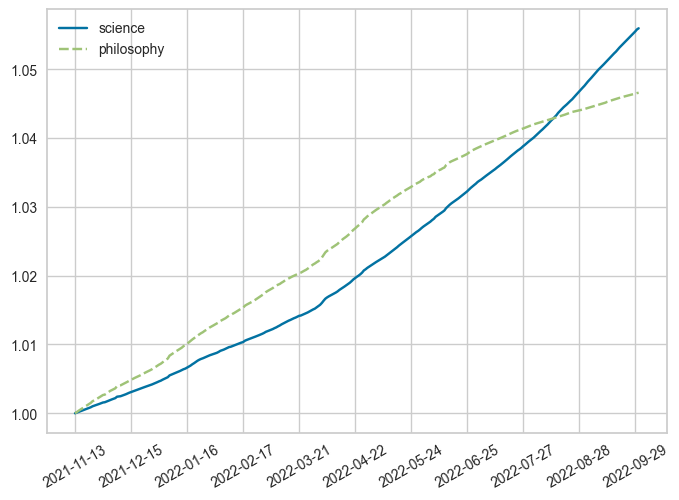

In [42]:
ax = sns.lineplot(data=subs);
ax.set_xticks(range(0,len(subs),32))
ax.set_xticklabels(subs['date'].values[::32], rotation=30);

We can see that while philosophy subreddit is subscribers is growing at a faster rate than that of science subscribers until it begins to taper off around 2022 July

# Preprocessing

## Get combined text column (retain deleted submissions)

In [43]:
science_df = science_org[['title','selftext','url','link_flair_text','subreddit']]
philosophy_df = philosophy_org[['title','selftext','url','link_flair_text','subreddit']]

In [44]:
#clean up the url column to only leave the domain
science_df['url'] = science_df['url'].apply(get_domain)
philosophy_df['url'] = philosophy_df['url'].apply(get_domain)

In [45]:
# combining selftext and title together
science_df['combined'] = science_df.loc[:,['title','selftext','url']].apply(lambda x : ' '.join(x.dropna().astype(str)), axis = 1)
philosophy_df['combined'] = philosophy_df.loc[:,['title','selftext','url']].apply(lambda x : ' '.join(x.dropna().astype(str)), axis = 1)

In [46]:
#store data for usage in other notebooks (eg. multiclass)
%store science_df

Stored 'science_df' (DataFrame)


In [47]:
combined_df_org = pd.concat([science_df[['combined','subreddit']], philosophy_df[['combined','subreddit']]], ignore_index = True)

In [48]:
combined_df_org['subreddit'] = combined_df_org['subreddit'].apply(lambda x: 1 if x == 'science' else 0)

In [49]:
combined_df_org

,combined,subreddit
0,Researchers identify the sodium leak channel n...,1
1,New study explores why people drop out or don'...,1
2,Dogs can discriminate between human baseline a...,1
3,A new look at an extremely rare female infant ...,1
4,Concussions are associated with 60% increase i...,1
...,...,...
49944,Friedrich Nietzsche - The Eternal Recurrence: ...,0
49945,Friedrich Nietzsche's Three Metamorphoses of t...,0
49946,An Overview of Friedrich Nietzsche's Idea of t...,0
49947,Worst enemies are only a step away from being ...,0


In [50]:
X_org_train, X_org_test, y_org_train, y_org_test = train_test_split(combined_df_org['combined'],
                                                                    combined_df_org['subreddit'],
                                                                    random_state=42,
                                                                    stratify=combined_df_org['subreddit'])

## Get combined text column (remove deleted submissions)

In [51]:
philosophy_df_mod = philosophy_df[philosophy_df['selftext']!='[removed]']

In [52]:
combined_df_mod = pd.concat([science_df[['combined','subreddit']], philosophy_df_mod[['combined','subreddit']]], ignore_index = True)

In [53]:
combined_df_mod['subreddit'] = combined_df_mod['subreddit'].apply(lambda x: 1 if x == 'science' else 0)

In [54]:
combined_df_mod

,combined,subreddit
0,Researchers identify the sodium leak channel n...,1
1,New study explores why people drop out or don'...,1
2,Dogs can discriminate between human baseline a...,1
3,A new look at an extremely rare female infant ...,1
4,Concussions are associated with 60% increase i...,1
...,...,...
35947,Friedrich Nietzsche - The Eternal Recurrence: ...,0
35948,Friedrich Nietzsche - The Eternal Recurrence: ...,0
35949,Friedrich Nietzsche's Three Metamorphoses of t...,0
35950,An Overview of Friedrich Nietzsche's Idea of t...,0


In [55]:
X_mod_train, X_mod_test, y_mod_train, y_mod_test = train_test_split(combined_df_mod['combined'],
                                                                    combined_df_mod['subreddit'],
                                                                    random_state=42,
                                                                    stratify=combined_df_mod['subreddit'])

# Other Functions

In [56]:
# A manual preprocessing function without using CountVectorizer
def manual_preprocess(sentence, do_lower = True, do_token = True, do_lemmatize = True, remove_stop = True):
    
    #lowercase all character in sentence
    if do_lower:
        sentence = sentence.lower()
    
    #Remove special character and tokenize
    if do_token:
        tokenizer = RegexpTokenizer(r'\w+')
        tokens = tokenizer.tokenize(sentence)
    
    #Lemmatize
    if do_lemmatize:
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]

    #Stop words removal
    if remove_stop:
        tokens = [token for token in tokens if token not in stopwords.words("english")]
    
    return tokens

def manual_preprocess_dfcolumn(column, do_lower = True, do_token = True, do_lemmatize = True, remove_stop = True):
    return column.apply(manual_preprocess, args=(do_lower,do_token,do_lemmatize,remove_stop))

In [57]:
# A manual matrix function without using CountVectorizer
def sparse_matrix(doc1, doc2, vocab={}):
    output_length = len(doc1)
    indptr = [0]
    indices = []
    data = []
    # if vocab is provided, just loop through doc1. Otherwise, loop through a combined df of doc1 and doc2 to output a combined dictionary
    if len(vocab)>0:
        docs = doc1
        vocabulary = vocab
    else:
        docs = pd.concat([doc1, doc2])
        vocabulary = {}
    for d in docs:
        for term in d:
            index = vocabulary.setdefault(term, len(vocabulary))
            indices.append(index)
            data.append(1)
        indptr.append(len(indices))

    return csr_matrix((data, indices, indptr), dtype=int)[:output_length], vocabulary

In [58]:
# function to output classification evaluation score
def display_score(model, X_train, y_train, X_test, y_test, y_pred):
    #Train score
    train_accuracy = model.score(X_train, y_train)
    train_cv_accuracy = cross_val_score(model, X_train, y_train).mean()
    #Test score
    test_accuracy = model.score(X_test, y_test)
    test_cv_accuracy = cross_val_score(model, X_test, y_test).mean()
    test_recall = recall_score(y_test, y_pred)
    test_precision = precision_score(y_test, y_pred)
    test_f1 = f1_score(y_test, y_pred)
    
    print(pd.DataFrame({
        'Train Scores':{
            'Accuracy':train_accuracy,
            'CV Accuracy':train_cv_accuracy,
        },
        'Test Scores':{
            'Accuracy':test_accuracy,
            'CV Accuracy':test_cv_accuracy,
            'Recall': test_recall,
            'Precision': test_precision,
            'F1': test_f1
        }
    }))
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Philosophy', 'Science'])
    disp.plot();

# Activate MLFlow

In [63]:
import mlflow 
mlflow.set_tracking_uri("sqlite:///mlflow.db") 
mlflow.set_experiment("GA-dsi32-project-3") 
# Start automatically logging all runs below to the created MLFlow experiment
mlflow.autolog()

2022/10/07 14:18:03 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2022/10/07 14:18:03 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.
2022/10/07 14:18:04 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


# Binary Classification Modeling
To classify subreddits into Science or Philosophy

## Baseline model (retain deleted submissions)

In [60]:
%%time
X_org_train_baseline = manual_preprocess_dfcolumn(X_org_train)
X_org_test_baseline = manual_preprocess_dfcolumn(X_org_test)

CPU times: total: 5min 8s
Wall time: 5min 37s


In [61]:
X_org_train_baseline, vocab = sparse_matrix(X_org_train_baseline, X_org_test_baseline)

In [62]:
X_org_test_baseline, _ = sparse_matrix(X_org_test_baseline, X_org_train_baseline, vocab)

In [62]:
mnb = MultinomialNB()

2022/10/04 09:13:07 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '1e47d45d8a2241578bdb095997f7c39e', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2022/10/04 09:13:44 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under ./mlruns/1/f8ce069a36674b48a72577cf1cf4c22b/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the tracking store. If logging to a mlflow server via REST, consider upgrading the server version to MLflow 1.7.0 or above.
2022/10/04 09:13:48 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under ./mlruns/1/f8ce069a36674b48a72577cf1cf4c22b/artifacts. 

             Train Scores  Test Scores
Accuracy         0.973679     0.963085
CV Accuracy      0.961400     0.954997
Recall                NaN     0.946964
Precision             NaN     0.978477
F1                    NaN     0.962462
CPU times: total: 3.83 s
Wall time: 46 s


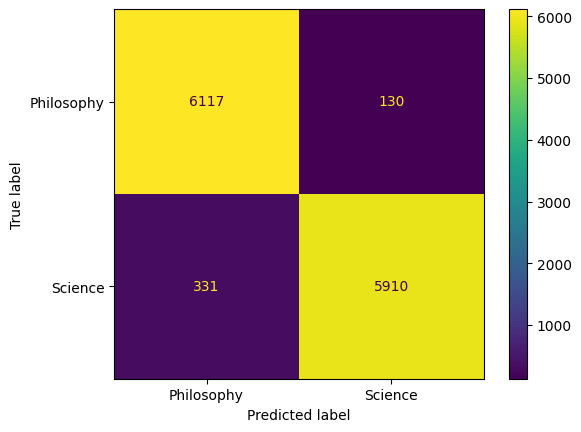

In [63]:
%%time
mnb.fit(X_org_train_baseline, y_org_train)
y_pred = mnb.predict(X_org_test_baseline)
with mlflow.start_run():
    display_score(mnb, X_org_train_baseline, y_org_train, X_org_test_baseline, y_org_test, y_pred)

## Baseline model (remove deleted submissions)

In [158]:
%%time
X_mod_train_baseline = manual_preprocess_dfcolumn(X_mod_train)
X_mod_test_baseline = manual_preprocess_dfcolumn(X_mod_test)

CPU times: total: 3min 55s
Wall time: 3min 57s


In [159]:
X_mod_train_baseline, vocab = sparse_matrix(X_mod_train_baseline, X_mod_test_baseline)

In [160]:
X_mod_test_baseline, _ = sparse_matrix(X_mod_test_baseline, X_mod_train_baseline, vocab)

In [161]:
mnb = MultinomialNB()

             Train Scores  Test Scores
Accuracy         0.969997     0.952937
CV Accuracy      0.952418     0.940810
Recall                NaN     0.955449
Precision             NaN     0.976257
F1                    NaN     0.965741
CPU times: total: 125 ms
Wall time: 402 ms


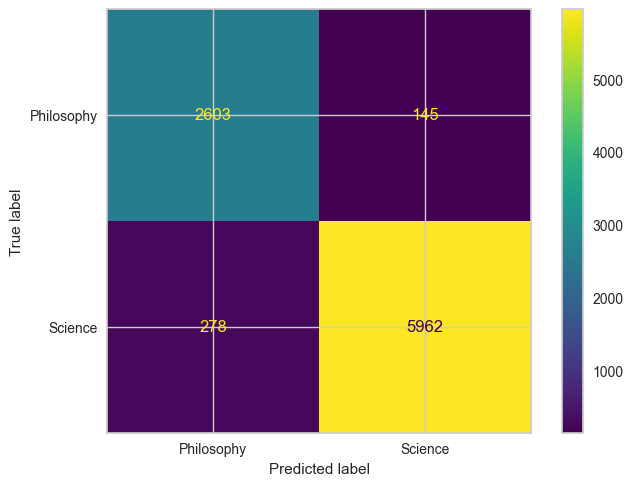

In [162]:
%%time
mnb.fit(X_mod_train_baseline, y_mod_train)
y_pred = mnb.predict(X_mod_test_baseline)
with mlflow.start_run():
    display_score(mnb, X_mod_train_baseline, y_mod_train, X_mod_test_baseline, y_mod_test, y_pred)

## CountVectorizer GridSearchCV with NB (retain deleted submissions)

In [64]:
pipe = Pipeline([
    ('cvec', CountVectorizer()), # tuple for transformer object, class
    ('nb', MultinomialNB()) # tuple for estimator object, class
])

In [65]:
pipe_params = {
    'cvec__stop_words': [None, 'english'],
    'cvec__token_pattern':['', '\w+'],
    'cvec__max_features': [None, 5000, 10000],
    'cvec__min_df': [1, 2],
    'cvec__max_df': [1.0, .9],
    'cvec__ngram_range': [(1,1), (1,2)],
    'cvec__binary':[True, False]
}

In [66]:
count_gs = GridSearchCV(pipe, # the object that we are optimizing
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5)

2022/10/05 19:05:42 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '8c77d7e033604814a6f0535a67e99950', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2022/10/05 19:32:27 INFO mlflow.sklearn.utils: Logging the 5 best runs, 187 runs will be omitted.
2022/10/05 19:56:29 INFO mlflow.sklearn.utils: Logging the 5 best runs, 187 runs will be omitted.
2022/10/05 20:19:39 INFO mlflow.sklearn.utils: Logging the 5 best runs, 187 runs will be omitted.
2022/10/05 20:46:36 INFO mlflow.sklearn.utils: Logging the 5 best runs, 187 runs will be omitted.
2022/10/05 21:08:11 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under ./mlruns/1/275cfe981c5147a8a1ed20c82659e32b/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record mod

             Train Scores  Test Scores
Accuracy         0.988628     0.970612
CV Accuracy      0.969034     0.965327
Recall                NaN     0.961064
Precision             NaN     0.979745
F1                    NaN     0.970315
CPU times: total: 2h 52min 53s
Wall time: 2h 59min 7s


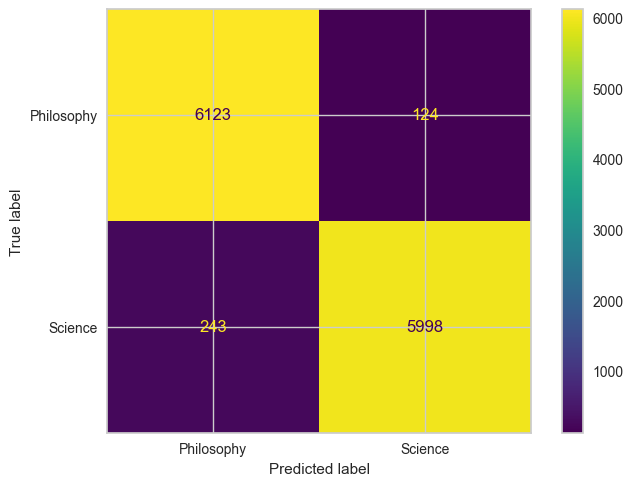

In [67]:
%%time
count_gs.fit(X_org_train, y_org_train)
y_pred = count_gs.predict(X_org_test)
with mlflow.start_run():
    display_score(count_gs, X_org_train, y_org_train, X_org_test, y_org_test, y_pred)

In [71]:
count_gs.best_params_

{'cvec__binary': True,
 'cvec__max_df': 1.0,
 'cvec__max_features': None,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': 'english',
 'cvec__token_pattern': '\\w+'}

## CountVectorizer GridSearchCV with NB (remove deleted submissions)

In [84]:
pipe = Pipeline([
    ('cvec', CountVectorizer()), # tuple for transformer object, class
    ('nb', MultinomialNB()) # tuple for estimator object, class
])

In [85]:
pipe_params = {
    'cvec__stop_words': [None, 'english'],
    'cvec__token_pattern':['', '\w+'],
    'cvec__max_features': [None, 5000, 10000],
    'cvec__min_df': [1, 2],
    'cvec__max_df': [1.0, .9],
    'cvec__ngram_range': [(1,1), (1,2)],
    'cvec__binary':[True, False]
}

In [86]:
count_gs2 = GridSearchCV(pipe, # the object that we are optimizing
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5)

2022/10/05 22:45:14 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '6052d7ac0fb042c187068f893de5423c', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2022/10/05 23:06:30 INFO mlflow.sklearn.utils: Logging the 5 best runs, 187 runs will be omitted.
2022/10/05 23:23:27 INFO mlflow.sklearn.utils: Logging the 5 best runs, 187 runs will be omitted.
2022/10/05 23:40:12 INFO mlflow.sklearn.utils: Logging the 5 best runs, 187 runs will be omitted.
2022/10/05 23:40:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 6c2d08a8f3ff412cb6c8e26276ba24b3. Failed operations: [MlflowException("Changing param values is not allowed. Params were already logged=\'[{\'key\': \'best_cvec__binary\

             Train Scores  Test Scores
Accuracy         0.987094     0.958945
CV Accuracy      0.962098     0.944147
Recall                NaN     0.975321
Precision             NaN     0.965878
F1                    NaN     0.970577
CPU times: total: 2h 11min 39s
Wall time: 2h 13min 27s


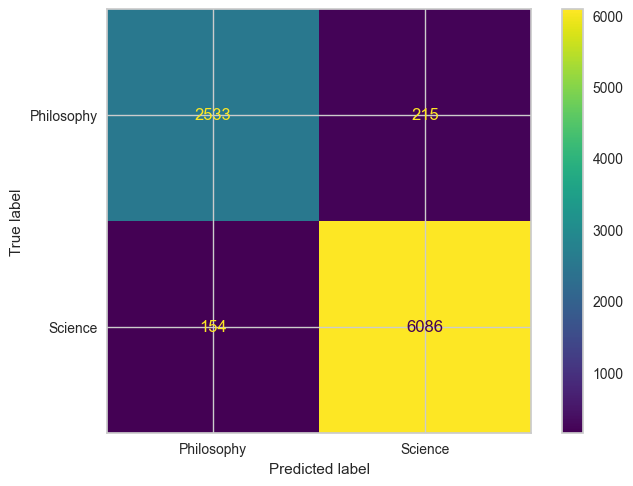

In [87]:
%%time
count_gs2.fit(X_mod_train, y_mod_train)
y_pred = count_gs2.predict(X_mod_test)
with mlflow.start_run():
    display_score(count_gs2, X_mod_train, y_mod_train, X_mod_test, y_mod_test, y_pred)

In [88]:
count_gs2.best_params_

{'cvec__binary': True,
 'cvec__max_df': 1.0,
 'cvec__max_features': None,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': 'english',
 'cvec__token_pattern': '\\w+'}

## TfidfVectorizer GridSearchCV with NB (retain deleted submissions)

In [89]:
pipetv = Pipeline([
    ('tvec', TfidfVectorizer()), # tuple for transformer object, class
    ('nb', MultinomialNB()) # tuple for estimator object, class
])

In [90]:
pipe_params_tv = {
    'tvec__stop_words': [None, 'english'],
    'tvec__token_pattern':['', '\w+'],
    'tvec__max_features': [None, 5000, 10000],
    'tvec__min_df': [1, 2],
    'tvec__max_df': [1.0, .9],
    'tvec__ngram_range': [(1,1), (1,2)],
    'tvec__binary':[True, False]
}

In [91]:
tvec_gs = GridSearchCV(pipetv, # the object that we are optimizing
                  param_grid=pipe_params_tv, # what parameters values are we searching?
                  cv=5)

2022/10/06 00:58:42 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '7d0b608fe7364c55aff7da52fb6c701b', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2022/10/06 01:24:38 INFO mlflow.sklearn.utils: Logging the 5 best runs, 187 runs will be omitted.
2022/10/06 01:45:23 INFO mlflow.sklearn.utils: Logging the 5 best runs, 187 runs will be omitted.
2022/10/06 02:06:13 INFO mlflow.sklearn.utils: Logging the 5 best runs, 187 runs will be omitted.
2022/10/06 02:26:54 INFO mlflow.sklearn.utils: Logging the 5 best runs, 187 runs will be omitted.
2022/10/06 02:47:34 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under ./mlruns/1/e91a3b4e300b418db9fd214541304815/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record mod

             Train Scores  Test Scores
Accuracy         0.988975     0.970372
CV Accuracy      0.969008     0.963966
Recall                NaN     0.965070
Precision             NaN     0.975385
F1                    NaN     0.970200
CPU times: total: 2h 42min 57s
Wall time: 2h 44min 29s


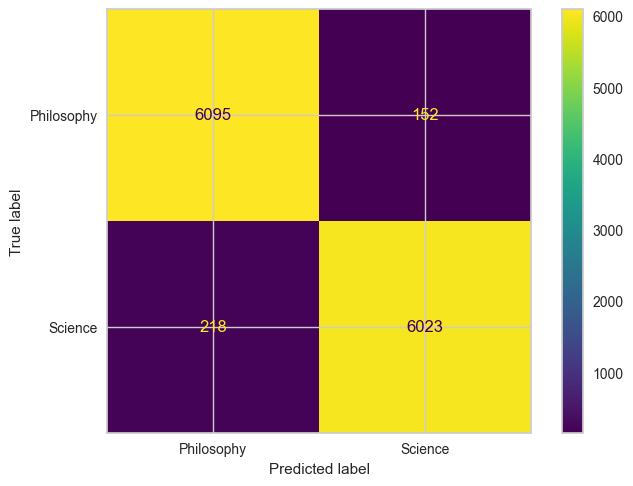

In [92]:
%%time
tvec_gs.fit(X_org_train, y_org_train)
y_pred = tvec_gs.predict(X_org_test)
with mlflow.start_run():
    display_score(tvec_gs, X_org_train, y_org_train, X_org_test, y_org_test, y_pred)

In [93]:
tvec_gs.best_params_

{'tvec__binary': True,
 'tvec__max_df': 1.0,
 'tvec__max_features': None,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': 'english',
 'tvec__token_pattern': '\\w+'}

## TfidfVectorizer GridSearchCV with NB (remove deleted submissions)

In [94]:
pipetv = Pipeline([
    ('tvec', TfidfVectorizer()), # tuple for transformer object, class
    ('nb', MultinomialNB()) # tuple for estimator object, class
])

In [95]:
pipe_params_tv = {
    'tvec__stop_words': [None, 'english'],
    'tvec__token_pattern':['', '\w+'],
    'tvec__max_features': [None, 5000, 10000],
    'tvec__min_df': [1, 2],
    'tvec__max_df': [1.0, .9],
    'tvec__ngram_range': [(1,1), (1,2)],
    'tvec__binary':[True, False]
}

In [96]:
tvec_gs2 = GridSearchCV(pipetv, # the object that we are optimizing
                  param_grid=pipe_params_tv, # what parameters values are we searching?
                  cv=5)

2022/10/06 03:43:12 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '0a6c978c9b764e79ac02a9c95ae62d6a', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2022/10/06 04:03:55 INFO mlflow.sklearn.utils: Logging the 5 best runs, 187 runs will be omitted.
2022/10/06 04:20:34 INFO mlflow.sklearn.utils: Logging the 5 best runs, 187 runs will be omitted.
2022/10/06 04:37:14 INFO mlflow.sklearn.utils: Logging the 5 best runs, 187 runs will be omitted.
2022/10/06 04:37:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID b22b51735eca45ba93bde571a017a2d3. Failed operations: [MlflowException("Changing param values is not allowed. Params were already logged=\'[{\'key\': \'best_tvec__min_df\

             Train Scores  Test Scores
Accuracy         0.962135     0.953494
CV Accuracy      0.953234     0.940588
Recall                NaN     0.969712
Precision             NaN     0.963535
F1                    NaN     0.966613
CPU times: total: 2h 11min 16s
Wall time: 2h 12min 47s


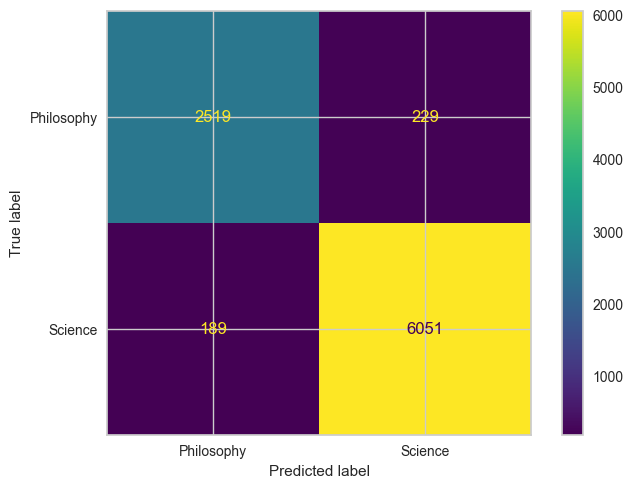

In [97]:
%%time
tvec_gs2.fit(X_mod_train, y_mod_train)
y_pred = tvec_gs2.predict(X_mod_test)
with mlflow.start_run():
    display_score(tvec_gs2, X_mod_train, y_mod_train, X_mod_test, y_mod_test, y_pred)

In [98]:
tvec_gs2.best_params_

{'tvec__binary': True,
 'tvec__max_df': 1.0,
 'tvec__max_features': 10000,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': 'english',
 'tvec__token_pattern': '\\w+'}

## Comparing between Random Forest and Extra Trees

In [61]:
cvec = CountVectorizer()
rfc = RandomForestClassifier(random_state=42, verbose = 1)
et = ExtraTreesClassifier(random_state=42, verbose = 1)

In [62]:
X_tree_train = cvec.fit_transform(X_org_train)
X_tree_test = cvec.transform(X_org_test)

In [64]:
cross_val_score(rfc, X_tree_train, y_org_train).mean()

2022/10/07 14:19:21 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '8272a133dd1d4ea88bfe1e149ab06448', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  

0.9600650801399333

In [66]:
cross_val_score(et, X_tree_train, y_org_train).mean()

2022/10/07 14:27:56 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '8cb2554580264682abe4938969d786e2', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  

0.9660179933732778

## CountVectorizer GridSearch CV with Random Forest Classifier (retain deleted submissions)
We will only do random forest classifier where we retain deleted submissions as it improve classification

In [125]:
pipe = Pipeline([
    ('cvec', CountVectorizer()), # tuple for transformer object, class
    ('rfc', RandomForestClassifier(random_state = 42, verbose = 1)) # tuple for estimator object, class
])

In [126]:
pipe_params = {
    'cvec__stop_words': ['english'], # we default this as it is shown to be the best param from previous model. Purpose to cut down modelling time
    'cvec__token_pattern':['\w+'], # we default this as it is shown to be the best param from previous model. Purpose to cut down modelling time
    #'cvec__max_features': [None, 5000, 10000], #we remove this as there's already max features in random forest
    'cvec__min_df': [1], # we default this as it is shown to be the best param from previous model. Purpose to cut down modelling time
    'cvec__max_df': [1.0], # we default this as it is shown to be the best param from previous model. Purpose to cut down modelling time
    'cvec__ngram_range': [(1,1), (1,2)],
    'cvec__binary':[True, False],
    'rfc__max_features' : ["sqrt", "log2"],
    'rfc__max_depth' : [None, 2, 5]
}

In [127]:
rfc = GridSearchCV(pipe, # the object that we are optimizing
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5)

2022/10/06 12:40:00 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '19382418629040a58ab697db8c621acb', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   22.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   23.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  

             Train Scores  Test Scores
Accuracy         0.998372     0.972534
CV Accuracy      0.968981     0.957960
Recall                NaN     0.967473
Precision             NaN     0.977339
F1                    NaN     0.972381
CPU times: total: 3h 10min 51s
Wall time: 3h 23min 56s


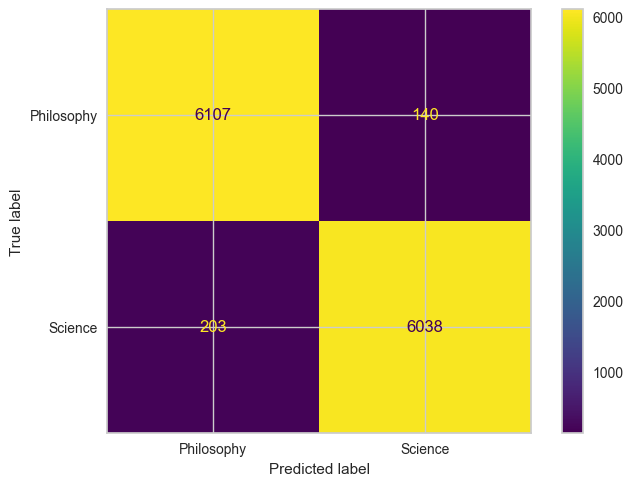

In [128]:
%%time
rfc.fit(X_org_train, y_org_train)
y_pred = rfc.predict(X_org_test)
with mlflow.start_run():
    display_score(rfc, X_org_train, y_org_train, X_org_test, y_org_test, y_pred)

# Save Model

Summary of results
Model | Preprocessing | CV Accuracy | 
-------- | ---------- | -------- |
MultinomialNB | Manual (all submissions) | 0.9550
MultinomialNB | Manual (remove deleted submissions) | 0.9408
MultinomialNB | CountVectorizer (all submissions) | 0.9653 *
MultinomialNB | CountVectorizer (remove deleted submissions) | 0.9441
MultinomialNB | TfidfVectorizer (all submissions) | 0.9640
MultinomialNB | TfidfVectorizer (remove deleted submissions) | 0.9406
Random Forest | CountVectorizer (all submissions) | 0.9601
Extra Forest | CountVectorizer (all submissions) | 0.9660
Random Forest | CountVectorizer (all submissions) | 0.9580

*We will be downloading the model which uses [CountVectorizer and MultinomialNB](##CountVectorizer-GridSearchCV-with-NB-(retain-deleted-submissions))  as it gives the highest cross validated accuracy at 96.53%. We do not consider our metrics for evaluation as the dataset is equally balanced

MLflow does not worked in this notebook although it was logged successfully. 2 main issues with downloaded mlflow model.
- The predictions always default to 1 no matter what input is fed in
- There's always only 1 prediction although multiple X values are fed in.These issues are not occuring in the model that we run in the above cells. 

As such, we proceeded with downloading the model manually using joblib

In [79]:
# As mlflow downloaded model does not work, we attempt to use another method to download the model based on link: https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/
# save the model to disk
import joblib
filename = './models/model_classify.pkl'
joblib.dump(count_gs, filename)

['./models/model_classify.pkl']

## Testing

In [100]:
# load the model from disk
loaded_model = joblib.load("./models/model_classify.pkl")

In [101]:
user_input = {"text": "Physicist Stephen Hawking dies aged 76 We regret to hear that Stephen Hawking died tonight at the age of 76. We are creating a megathread for discussion of this topic here. The typical r/science comment rules will not apply and we will allow mature, open discussion. This post may be updated as we are able. A few relevant links: Stephen Hawking's AMA on /r/science. BBC's Obituary for Stephen Hawking. If you would like to make a donation in his memory, the Stephen Hawking Foundation has the Dignity Campaign to help buy adapted wheelchair equipment for people suffering from motor neuron diseases. You could also consider donating to the ALS Association to support research into finding a cure for ALS and to provide support to ALS patients. http://www.bbc.com/news/uk-43396008"}

In [102]:
user_input1 = {"text": "Only fragments of ancient Greek philosopher Epicurus’s writings remain. Among them are his Principal Doctrines: 40 brilliant, authoritative aphorisms that summarize the Epicurean approach to living a good life — an approach focused on removing pain & anxiety, & on emphasizing friendship & community. https://philosophybreak.com/articles/epicurus-principal-doctrines-40-aphorisms-for-living-well/?utm_source=reddit&utm_medium=social"}

In [104]:
loaded_model.predict(pd.Series(user_input['text']))

array([1], dtype=int64)